In [1]:
import string
from string import punctuation
from os import listdir
from collections import Counter
import re
import unicodedata

import pandas as pd
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk    
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet

[nltk_data] Downloading package stopwords to /home/amina/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/amina/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
import pickle

# Étape 1 : Télécharger et importer les données

Les données qui nous intéressent sont des commentaires de films. 

Nous avons utilisé les données <a href="http://ai.stanford.edu/~amaas/data/sentiment/">IMDb Reviews</a>. On peut les télécharger facilement en cliquant sur ce lien, puis sur "Large Movie Review Dataset v1.0". Le fichier aclImdb_v1.tar.gz sera alors téléchargé. Il suffira de l'extraire puis d'utiliser les fichiers .txt dans les dossiers neg et pos.

Nous importons maintenant les commentaires positifs et négatifs, en les mettant dans des listes negative_dataset et positive_dataset.

In [21]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

negative_dataset = []
for filename in listdir('/home/amina/Documents/aclImdb/train/neg'):
    if not filename.endswith(".txt"):
        continue
    path = '/home/amina/Documents/aclImdb/train/neg' + '/' + filename
    read_file = load_doc(path)
    negative_dataset.append(read_file)  
    
positive_dataset = []
for filename in listdir('/home/amina/Documents/aclImdb/train/pos'):
    if not filename.endswith(".txt"):
        continue
    path = '/home/amina/Documents/aclImdb/train/pos' + '/' + filename
    read_file = load_doc(path)
    positive_dataset.append(read_file)

In [22]:
n_neg = len(negative_dataset)
n_pos = len(positive_dataset)
print(n_pos + n_neg)

25000


Nous avons alors un jeu de données de 22704 commentaires.

# Étape 2 : Pré-traitement des données

Les commentaires bruts contiennent beaucoup de caractères, de ponctuation notamment qui ne nous permettront pas de faire une étude correcte sur ces commentaires.
Il faut alors "nettoyer" nos données.

Voici un exemple de commentaire "brut".

In [23]:
negative_dataset[1]

'You ever get that itch to just kill an hour or two doing chores and watching a movie so bad it defies reason? Well, out renting movies one weekend i see the box art for this one and see the T-Rex. Knowing full well that the dinosaur on the package was the T-Rex from Jurassic Park, I KNEW I had to rent this just cause I was in the mood for a bad movie.<br /><br />I was not disappointed in the least.<br /><br />Mad scientists, secret formulas, a company more concerned about its fortune and shareholders than lives, and of course, a big, poorly animated, sock-puppet T-Rex. Is it me our through out the movie was there scenes clearly spliced from other movies? Not to mention the Rex\'s hungry is never satisfied...ever. How he has hungry is beyond me because he actually doesn\'t have an throat (Really if you look down his mouth when he roars, it\'s solid...like a toy or something). Now, I like watching incredibly bad B-Movies from time to time because it reminds me how much better a blockbus

Pour ce faire, on peut choisir de :

 - Segmenter les commentaire en "tokens", ici un token représentera un mot
 - Supprimer la ponctuation
 - Supprimer tous les nombres et caractères spéciaux
 - Mettre tout en minuscule
 - Supprimer les mots à une lettre
 - Supprimer les mots tels que "the", this"... appelés "stopwords"
 - Lemmatiser, c'est-à-dire, prendre la racine des mots. Par exemple, les mots "stepping", "stepped", "steps" seront transformés en "step"

On utilise la librairie nltk pour la lemmatisation.

In [24]:
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer() 

On écrit alors la fonction qui va nous permettre de "nettoyer" les commentaires.

In [25]:
def clean_doc(doc):
    # tokenisation
    tokens = nltk.word_tokenize(doc)
    # suppression de la ponctuation
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    tokens = [w.translate(table) for w in tokens]
    # remplacement des espaces multiples en un seul espace
    tokens = [re.sub(r'\s+', ' ', word, flags=re.I) for word in tokens]
    # suppression des caractères spéciaux
    tokens = [word for word in tokens if word.isalpha()]
    # minuscule
    tokens = [word.lower() for word in tokens]
    # suppression des tokens de longueur inférieure à 1
    tokens = [word for word in tokens if len(word) > 1]
    # suppression des stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # lemmatisation
    tokens = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens]
    # étant donné que les commentaires concernent des films on supprime les mots "basiques"
    basic_words = ['film', 'movie', 'one', 'character', 'scene', 'make', 'see', 'go','story','time','br']
    tokens = [w for w in tokens if not w in basic_words]
    return tokens

On crée également un dictionnaire "vocab" contenant tous les mots de ce corpus.

In [27]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/amina/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [29]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/amina/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [30]:
vocab = Counter()
tidy_review_neg = []

for review in negative_dataset:
    token = clean_doc(review)
    vocab.update(token)
    review = ' '.join(word for word in token)
    tidy_review_neg.append(review)
    
tidy_review_pos = []

for review in positive_dataset:
    token = clean_doc(review)
    vocab.update(token)
    review = ' '.join(word for word in token)
    tidy_review_pos.append(review)

In [31]:
print("Le vocabulaire contient : %s mots" 
       % len(vocab))

Le vocabulaire contient : 57942 mots


On obtient alors ce commentaire "nettoyé".

In [32]:
tidy_review_neg[1]

'ever get itch kill hour two chore watch bad defies reason well rent weekend box art know full well dinosaur package jurassic park knew rent cause mood bad disappointed mad scientist secret formula company concerned fortune shareholder life course big poorly animate clearly splice mention rex hungry never satisfied ever hungry beyond actually throat really look mouth roar solid like toy something like watch incredibly bad reminds much well blockbuster hilarious even sure suppose thriller comedy mistake laugh blame budget yes act help either ok tony todd actually pretty good female role cry tear come meh angry knew get look bad watch friend recommend watch immediately watch jurassic park lose world back back write spielberg thank letter next day'

In [33]:
data_neg = {'Reviews':negative_dataset,'Tidy_Reviews':tidy_review_neg, 'label': [1]*n_neg}
data_neg = pd.DataFrame(data_neg)
data_pos = {'Reviews':positive_dataset, 'Tidy_Reviews':tidy_review_pos, 'label': [0]*n_pos}
data_pos = pd.DataFrame(data_pos)

In [34]:
dataset = pd.concat([data_neg, data_pos])

On a le dataset suivant où les commentaires négatifs sont labélisés 1, et les commentaires positifs sont labélisés 0.

In [1]:
dataset.head(5)

NameError: name 'dataset' is not defined

In [36]:
dataset.to_pickle("clean_data.pkl") 

On peut ensuite choisir de représenter les mots les plus fréquents dans les commentaires positifs et négatifs.

Pour cela, on utilise la librairie wordcloud. Les mots les plus fréquents sont de grandes tailles.

In [68]:
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests

 - Les mots dans les commentaires positifs

In [83]:
all_words_positive = ' '.join(text for text in dataset['Tidy_Reviews'][dataset['label']==0])
Mask = np.array(Image.open('movie1.jpg'))
image_colors = ImageColorGenerator(Mask)
wc = WordCloud(background_color='white', height=1500, width=4000,mask=Mask).generate(all_words_positive)

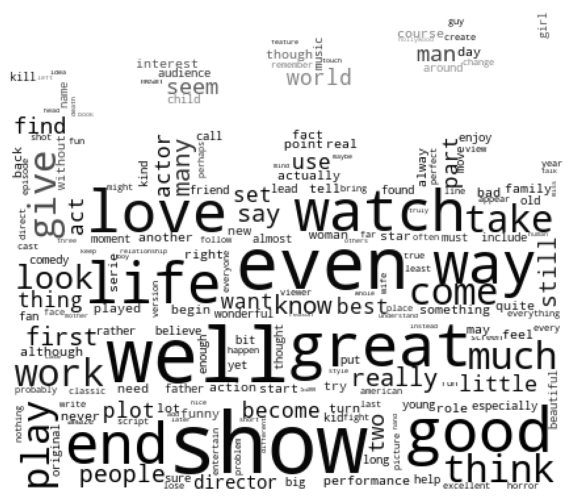

In [84]:
plt.figure(figsize=(10,20))
plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")
plt.axis('off')
plt.show()

 - Les mots dans les commentaires négatifs

In [86]:
all_words_negative = ' '.join(text for text in dataset['Tidy_Reviews'][dataset['label']==1])
Mask = np.array(Image.open('movie1.jpg'))
image_colors = ImageColorGenerator(Mask)
wc = WordCloud(background_color='white', height=1500, width=4000,mask=Mask).generate(all_words_negative)

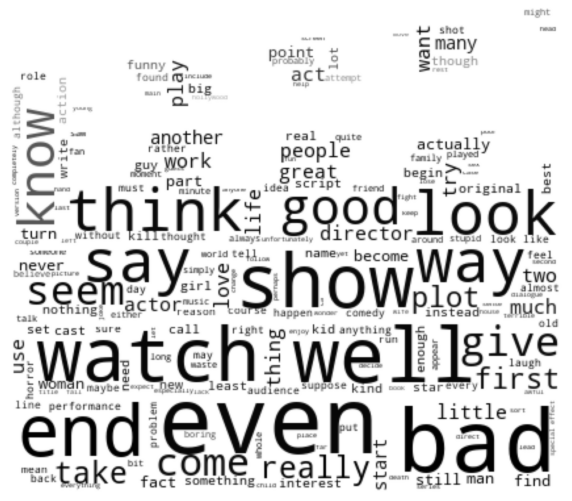

In [87]:
plt.figure(figsize=(10,20))
plt.imshow(wc.recolor(color_func=image_colors),interpolation="gaussian")
plt.axis('off')
plt.show()

On remarque que les mots qui ressortent des commentaires positifs sont plutôt positifs et que ceux des commentaires négatifs sont négatifs ou neutres. 
Par exemple, "show", "watch" sont des mots sans connotations particulières qui sont fréquents à la fois dans les commentaires positifs et négatifs.

 - Dans tous le dataset

In [195]:
freq_words = pd.DataFrame({'Word':list(vocab.keys()),'Count':list(vocab.values())})
freq_words.to_pickle("vocab.pkl") 

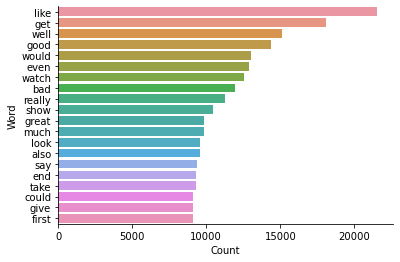

In [90]:
freq_words_plot = freq_words.nlargest(20,columns='Count')
sns.barplot(data=freq_words_plot,y='Word',x='Count')
sns.despine()

Le mot le plus fréquent est "like".

# Étape 3 : Vectorisation

Pour que nos données puissent être comprises par les algorithmes de Machine Learning, on doit convertir les commentaires en représentation numérique.

On sépare d'abord nos données en données d'entraînement et en données de test.

In [92]:
from sklearn.model_selection import train_test_split

In [197]:
# mélanger les données
dataset = dataset.sample(frac=1)

In [106]:
reviews_train, reviews_test, label_train, label_test = train_test_split(dataset["Tidy_Reviews"], dataset["label"], test_size=0.33, random_state=42)

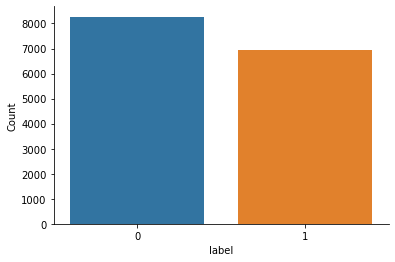

In [155]:
l = Counter(label_train)
labels = pd.DataFrame({'label':list(l.keys()),'Count':list(l.values())})
sns.barplot(data=labels,x='label',y='Count')
sns.despine()

On observe que dans notre jeu de données d'entraînement il y a un peu plus de commentaire positifs que de commentaires négatifs. Mais le jeu reste tout de même assez équilibré.

## Bag-of-word

Nous utilisons dans un premier temps, la représentation appelée "Bag-of-word.
Elle consiste à créer une grande matrice avec une colonne pour chaque mot unique dans le corpus.
Chaque commentaire correspond à une ligne contenant des 0 et des 1, où 1 signifie que le mot dans le corpus correspondant à cette colonne apparaît dans ce commentaire.
Chaque ligne de la matrice sera alors creuse, car il y aura beaucoup de zéros.
Ce processus est également appelé "one hot encoding".

In [131]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(binary=True)
cv.fit(reviews_train)
X = cv.transform(reviews_train)
X_test = cv.transform(reviews_test)

## TF-IDF

On peut également utiliser la représentation TF-IDF, elle permet d'évaluer l'importance d'un terme contenu dans un document.

### Term Frequency (TF)

TF représente le nombre de fois qu'un mot apparaît dans un commentaire divisé par le nombre total de mots dans le commentaire.
Chaque commentaire a son propre TF.

$$\mathrm{tf_{i,j}} = \frac{n_{i,j}}{\sum_k n_{i,j}}$$

### Inverse Data Frequency (IDF)

IDF représente le log du nombre de documents divisé par le nombre de documents qui contiennent le mot $t_i$.
IDF determine le poids des mots rares pour tous les commentaires du corpus.

$$\mathrm{idf_i} =  \log \frac{|D|}{|\{d_{j}: t_{i} \in d_{j}\}|}$$

où 
 - $|D|~$ : nombre total de commentaires dans le corpus 
 - $|\{d_{j} : t_{i} \in d_{j}\}|$ : nombre de commentaires où le terme $t_i$ apparaît (c'est-à-dire $n_{i,j} \neq 0$)

Et enfin, TF-IDF est simplement le TF multiplié par le IDF.

$$\mathrm{tfidf_{i,j}} = \mathrm{tf_{i,j}} \cdot  \mathrm{idf_{i}}$$

In [150]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(reviews_train)
X_tfidf = tfidf_vectorizer.transform(reviews_train)
X_test_tfidf = tfidf_vectorizer.transform(reviews_test)

# Étape 4 : Application d'algorithmes de ML

Nous allons maintenant appliquer différents algorithmes de Machine Learning, pour pouvoir déterminer quels algorithmes prédisent le mieux le caractère positif ou négatif des commentaires. 

Nous utilisons ici comme métrique l'accuracy qui peut s'écrire :

$$accuracy = \frac{TP+TN}{TP+TN+FP+FN}\,,$$
où : 
 - TP : vrais positifs
 - TN : vrais négatifs
 - FP : faux positifs
 - FN : faux négatifs
 

## Régression logistique

La régression logistique est un algorithme de Machine Learning qui est utilisé pour prédire la probabilité d'une variable binaire (ici il s'agit de 0 : commentaire positif et 1 : commentaire négatif).

On fait une régression logistique qui utilise une régression Ridge (penalty='l2') de paramètre C.

### Avec Bag-of-word

In [137]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train, X_val, y_train, y_val = train_test_split(X, label_train, train_size = 0.75)

for c in [0.01, 0.05, 0.25, 0.5, 1]:    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" % (c, accuracy_score(y_val, lr.predict(X_val))))

Accuracy for C=0.01: 0.8569550354982908
Accuracy for C=0.05: 0.8661582960820405
Accuracy for C=0.25: 0.8666841966868262
Accuracy for C=0.5: 0.8632658427557192
Accuracy for C=1: 0.8564291348935051


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pour C = 0.25, on a l'accuracy la plus élevée.

On applique ce modèle.

In [139]:
final_model = LogisticRegression(C=0.25)
final_model.fit(X, label_train)
print ("Final Accuracy: %s" 
       % accuracy_score(label_test, final_model.predict(X_test)))

Final Accuracy: 0.8737488322434273


On trouve une accuracy d'environ 0.87.

On peut également regarder les 5 mots les plus discriminant pour les commentaires négatifs et positifs.
On regarde alors respectivement les plus grands et les plus petits coefficients.

In [143]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.coef_[0])
}
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_negative)

('waste', 1.4895652010033988)
('poorly', 1.3579970245928252)
('disappointment', 1.3332970919160059)
('awful', 1.252963938869019)
('bad', 1.1759171172232066)


In [144]:
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_positive)

('excellent', -1.1134926214121479)
('refresh', -1.0787223566256654)
('funniest', -1.0304318074611853)
('enjoyable', -0.9619662787692432)
('rare', -0.9064231410350329)


### Avec TF-IDF

In [161]:
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, label_train, train_size = 0.75)

for c in [0.01, 0.05, 0.25, 0.5, 1]:    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" % (c, accuracy_score(y_val, lr.predict(X_val))))
    

Accuracy for C=0.01: 0.5787536155666579
Accuracy for C=0.05: 0.7675519326847225
Accuracy for C=0.25: 0.8356560610044702
Accuracy for C=0.5: 0.8551143833815409
Accuracy for C=1: 0.8640546936628977
Final Accuracy: 0.85546510076071


In [162]:
final_model = LogisticRegression(C=1)
final_model.fit(X, label_train)
print ("Final Accuracy: %s" 
       % accuracy_score(label_test, final_model.predict(X_test_tfidf)))

Final Accuracy: 0.8777525690644602


On trouve une accuracy de 0.88.

In [165]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.coef_[0])
}
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_negative)

('bad', 9.434439459651786)
('waste', 6.0513382440271135)
('awful', 5.0149083071824965)
('poor', 4.468799560156217)
('nothing', 4.401751160525424)


In [164]:
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_positive)

('great', -6.518068450757326)
('excellent', -4.838011788457555)
('love', -4.404042688360875)
('best', -4.137042383058063)
('enjoy', -3.9145918808928815)


## SVM

On utilise également la régularisation Ridge(l2) de paramètre C.

### Avec bag-of-word

In [167]:
from sklearn.svm import LinearSVC

X_train, X_val, y_train, y_val = train_test_split(
    X, label_train, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    svm = LinearSVC(C=c)
    svm.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, svm.predict(X_val))))

Accuracy for C=0.01: 0.8004207204838285
Accuracy for C=0.05: 0.8564291348935051
Accuracy for C=0.25: 0.8729950039442546
Accuracy for C=0.5: 0.8732579542466474
Accuracy for C=1: 0.8708914015251118


ValueError: Found input variables with inconsistent numbers of samples: [15211, 25000]

In [168]:
final_svm_ngram = LinearSVC(C=0.5)
final_svm_ngram.fit(X, label_train)
print ("Final Accuracy: %s" 
       % accuracy_score(label_test, final_svm_ngram.predict(X_test)))

Final Accuracy: 0.8844254637661818


### Avec TF-IDF

In [169]:
from sklearn.svm import LinearSVC

X_train, X_val, y_train, y_val = train_test_split(
    X_tfidf, label_train, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    svm = LinearSVC(C=c)
    svm.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, svm.predict(X_val))))

Accuracy for C=0.01: 0.8161977386273994
Accuracy for C=0.05: 0.8653694451748619
Accuracy for C=0.25: 0.8821982645280042
Accuracy for C=0.5: 0.8811464633184328
Accuracy for C=1: 0.8764133578753616


In [171]:
final_svm = LinearSVC(C=0.25)
final_svm.fit(X_tfidf, label_train)
print ("Final Accuracy: %s" 
       % accuracy_score(label_test, final_svm.predict(X_test_tfidf)))

Final Accuracy: 0.885092753236354


On trouve à peu près la même valeur pour l'accuracy avec les counts et avec tfidf.

## Random Forest

### Avec Bag-of-word

In [172]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X, label_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [173]:
print ("Final Accuracy: %s" % accuracy_score(label_test, final_rf.predict(X_test)))

Final Accuracy: 0.8401174429467503


### Avec TF-IDF

In [175]:
rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=0)
rf_tfidf.fit(X_tfidf, label_train)
print ("Final Accuracy: %s" % accuracy_score(label_test, rf_tfidf.predict(X_test_tfidf)))

Final Accuracy: 0.8401174429467503


# Étape 5 : Comparaison des modèles

Pour comparer les différents modèles, on fait une validation croisée en 10 folds.

LR: 0.852607 (0.009145)
SVM: 0.883244 (0.008723)
RF: 0.835186 (0.009126)


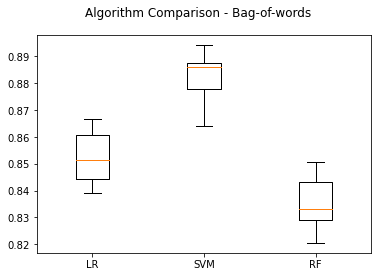

In [191]:
from sklearn import model_selection
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression(C=0.25)))
models.append(('SVM', LinearSVC(C=0.5)))
models.append(('RF', RandomForestClassifier(n_estimators=100, random_state=0)))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X, label_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison - Bag-of-words')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

On trouve que SVM nous donne la meilleure accuray.

LR: 0.852607 (0.009145)
SVM: 0.883244 (0.008723)
RF: 0.835186 (0.009126)


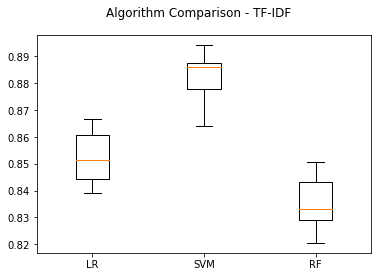

In [202]:
names = []
results = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X_tfidf, label_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison - TF-IDF')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Conclusion